# Embedding Generation Notebook

## Objective
This notebook demonstrates how to use custom encoder models to generate embeddings from the MNIST dataset. These models are implemented in `encoder_models.py`, and the training processes are defined in `encoder_training.py`.

## Workflow
1. **Load and Preprocess Data**:
   - Load the MNIST dataset for testing the embedding generation process.
   - Normalize and prepare the data.
2. **Model Selection and Training**:
   - Train selected encoder models from `encoder_models.py`.
   - Generate embeddings from the bottleneck layer.
3. **Feature Extraction**:
   - Generate embeddings using matrix factorization (PCA, SVD, NMF) and SIFT.
4. **Save Embeddings**:
   - Save all embeddings and trained models for reuse.

## Models and Methods
### Supported Models
The following encoder models are available for training and embedding generation. Each model is implemented in `encoder_models.py`:
- **Encoder Models**:
  - BasicAutoencoder, IntermediateAutoencoder, AdvancedAutoencoder, EnhancedAutoencoder.
  - BasicVAE, VAEWithFCDecoder, ImprovedVAE, FlexibleVAE.
- **Feature Extraction**:
  - PCA, SVD, NMF.
  - SIFT, Kernel PCA.

#### **Autoencoders**
1. **BasicAutoencoder**:
   - A simple autoencoder with:
     - **Encoder**: Two convolutional layers followed by max-pooling.
     - **Decoder**: Two transposed convolutional layers to reconstruct the input.
   - Designed for grayscale datasets like MNIST.
   - Suitable for basic dimensionality reduction and reconstruction tasks.

2. **IntermediateAutoencoder**:
   - A deeper autoencoder with:
     - **Batch Normalization** for improved stability.
     - Additional feature maps for a more expressive latent space.
   - Designed for moderately complex embedding tasks requiring better feature extraction.

3. **AdvancedAutoencoder**:
   - A sophisticated autoencoder with:
     - **Skip Connections** to improve gradient flow and reconstruction accuracy.
     - **LeakyReLU Activations** and Batch Normalization for robust performance.
   - Suitable for high-dimensional or structured data requiring detailed reconstruction.

4. **EnhancedAutoencoder**:
   - A deeper autoencoder with:
     - Additional convolutional layers in the encoder.
     - Transposed convolutional layers in the decoder.
     - LeakyReLU activations and Batch Normalization for better embedding representation.
   - Designed for datasets requiring intricate reconstructions under noisy conditions.

#### **Variational Autoencoders (VAEs)**
5. **BasicVAE**:
   - A simple VAE with:
     - **Encoder**: Two convolutional layers and a fully connected layer to parameterize the latent space.
     - **Decoder**: Fully connected and transposed convolution layers to reconstruct input images.
   - Suitable for generative tasks with simple latent spaces.

6. **VAEWithFCDecoder**:
   - A VAE with a fully connected decoder for enhanced latent-to-feature mapping.
   - Features:
     - **Encoder**: Convolutional layers with Batch Normalization.
     - **Decoder**: A combination of fully connected and transposed convolutional layers.

7. **ImprovedVAE**:
   - An advanced VAE with:
     - A bottleneck layer for enhanced feature extraction.
     - Transposed convolutions for smooth reconstructions.
     - KL divergence loss for latent space regularization.
   - Designed for datasets requiring expressive latent representations.

8. **FlexibleVAE**:
   - A flexible VAE that supports dynamic input shapes and optional projection heads for contrastive learning.
   - Suitable for embedding tasks with varying input dimensions.

9. **ImprovedFlexibleVAE**:
   - Combines convolutional and fully connected layers in the encoder.
   - Uses transposed convolutions in the decoder for better reconstruction.
   - Optional **Projection Head** for self-supervised contrastive learning tasks.

#### **Denoising Autoencoders**
10. **DenoisingAutoencoder**:
    - A denoising autoencoder with:
      - **Encoder**: Convolutional layers for feature extraction.
      - **Decoder**: Transposed convolutional layers for reconstruction.
      - Optional **Projection Head** for contrastive learning.
    - Supports two architectures:
      - **Basic**: Simpler structure for standard denoising tasks.
      - **Strong**: Deeper architecture for challenging noisy datasets.

#### **Feature Extraction and Normalizing Flow Models**
11. **Matrix Factorization**:
    - Embeddings generated using PCA, SVD, and NMF.
    - Useful for dimensionality reduction and compact representations.

12. **SIFT (Scale-Invariant Feature Transform)**:
    - Extracts scale-invariant features from images.
    - Pads feature descriptors to ensure consistent dimensionality.

13. **Kernel PCA**:
    - Nonlinear dimensionality reduction using Kernel PCA with adjustable kernels.

14. **Normalizing Flow Models**:
    - Transforms embeddings into a latent space using invertible transformations.
    - Useful for embedding refinement and generative tasks.


**Training**:
   - Each model is trained using the corresponding training loop defined in `encoder_training.py`.
   - Training includes support for reconstruction loss, KL divergence (for VAE), and optional noise injection.
**Embedding Generation**:
   - Once the models are trained, embeddings are generated for the MNIST dataset.
   - Encodings from the bottleneck layer are extracted for downstream tasks.
**Results Storage**:
   - Save trained models to `.pth` files.
   - Save generated embeddings to `.pt` files for reuse in downstream applications.

## Supported Features
- **Flexible Model Selection**:
  - Choose specific models to train and generate embeddings for, bypassing others if needed.
- **Custom Configuration**:
  - Easily modify parameters like the bottleneck size (`code_dim`), number of training epochs, and learning rates.

## Outputs
- Trained models saved as `.pth` files.
- Generated embeddings saved as `.pt` files in a structured directory (`./embeddings`).

## Notes
This notebook is designed for flexibility and reusability. You can:
- Add new encoder models in `encoder_models.py`.
- Customize training loops in `encoder_training.py`.
- Modify this notebook to train specific models or generate embeddings for specific datasets.


In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# Mount Google Drive and set repository path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Repository path (adjust if needed)
repo_path = "/content/drive/MyDrive/GAN-thesis-project"

# Add repository path to sys.path for module imports
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Change working directory to the repository
os.chdir(repo_path)

# Verify the working directory
print(f"Current working directory: {os.getcwd()}")

# Configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/GAN-thesis-project
Using device: cpu


In [7]:
import inspect

# Import the entire modules
import src.data_utils as data_utils
import src.cl_loss_function as cl_loss
import src.losses as losses
import src.embeddings.encoder_models as encoder_models
import src.embeddings.encoder_training as encoder_training

# Function to list functions and classes in a module
def list_functions_and_classes(module):
    members = inspect.getmembers(module)
    functions = [name for name, obj in members if inspect.isfunction(obj)]
    classes = [name for name, obj in members if inspect.isclass(obj)]
    return functions, classes

# Function to print functions and classes in a readable format
def print_functions_and_classes(module_name, module):
    functions, classes = list_functions_and_classes(module)
    print(f"Module: {module_name}")
    print("  Functions:")
    for func in functions:
        print(f"    - {func}")
    print("  Classes:")
    for cls in classes:
        print(f"    - {cls}")
    print()  # Add a blank line for separation

# Print functions and classes for each module
print_functions_and_classes("src.data_utils", data_utils)
print_functions_and_classes("src.cl_loss_function", cl_loss)
print_functions_and_classes("src.losses", losses)
print_functions_and_classes("src.embeddings.encoder_models", encoder_models)
print_functions_and_classes("src.embeddings.encoder_training", encoder_training)

Module: src.data_utils
  Functions:
    - analyze_embeddings
    - analyze_embeddings_v2
    - create_dataloader
    - create_embedding_loaders
    - kurtosis
    - load_data
    - load_embeddings
    - load_mnist_data
    - pdist
    - preprocess_images
    - save_embeddings
    - skew
    - split_dataset
    - train_test_split
    - visualize_embeddings
  Classes:
    - DataLoader
    - LocalOutlierFactor
    - TensorDataset

Module: src.cl_loss_function
  Functions:
    - augment
    - compute_nt_xent_loss_with_augmentation
    - compute_triplet_loss_with_augmentation
    - contrastive_loss
    - hflip
    - info_nce_loss
    - resize
  Classes:
    - ContrastiveHead
    - DataLoader
    - NTXentLoss
    - PCA
    - TensorDataset
    - TripletLoss
    - VicRegLoss

Module: src.losses
  Functions:
    - add_noise
    - cyclical_beta_schedule
    - linear_beta_schedule
    - loss_function_dae_ssim
    - vae_loss
    - vae_ssim_loss
  Classes:

Module: src.embeddings.encoder_models
  F

Sampled Dataset: (70000, 1, 28, 28) (70000,)
Batch Shape: torch.Size([64, 1, 28, 28]) torch.Size([64])


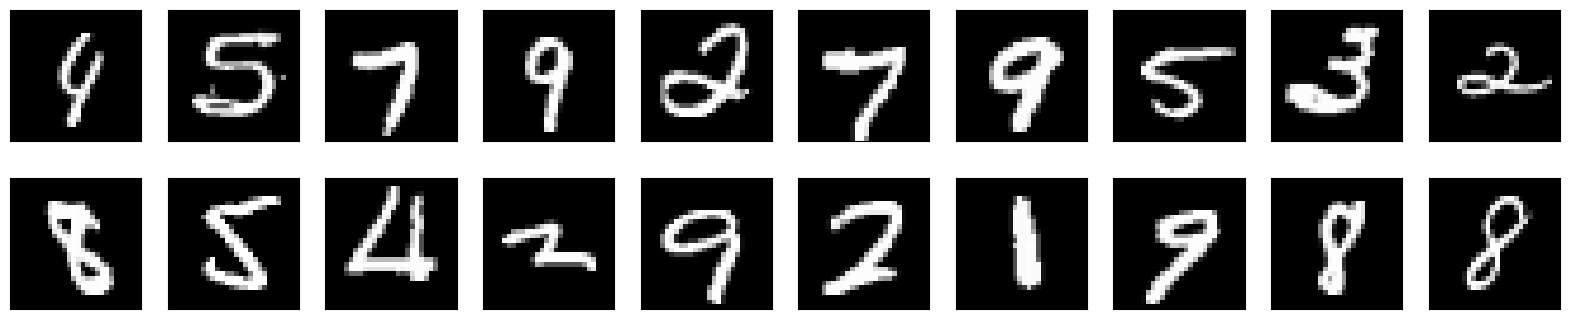

In [8]:
# Load and Preprocess MNIST Data
fraction = 1  # Fraction of the dataset to use
batch_size = 64

# Load Combined MNIST Dataset (Train + Test)
mnist_loader = data_utils.load_mnist_data(fraction=fraction, batch_size=batch_size, shuffle=True)

# Inspect Combined Dataset
for batch in mnist_loader:
    images, labels = batch
    print("Batch Shape:", images.shape, labels.shape)
    break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [9]:
from typing import Callable, Optional

def train_autoencoder(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    device: str = "cpu",
    noise_factor: float = 0.0,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    contrastive_loss_fn: Optional[Callable] = None,
    temperature: float = 0.5,
    triplet_data: bool = False,
    augment_fn: Optional[Callable] = None,
):
    """
    Unified training function for autoencoders with support for:
    - Reconstruction loss
    - Contrastive loss (e.g., NT-Xent, InfoNCE)
    - Triplet loss
    - Noise injection (for denoising autoencoders)
    - Data augmentation

    Args:
        model (nn.Module): The autoencoder model.
        data_loader (DataLoader): DataLoader for training data.
        loss_fn (Callable): Primary loss function (e.g., reconstruction loss).
        optimizer (optim.Optimizer): Optimizer for the model.
        epochs (int): Number of epochs to train.
        device (str): Device to train on ('cpu' or 'cuda').
        noise_factor (float): Factor for adding noise to input images (denoising autoencoder).
        scheduler (Optional[optim.lr_scheduler._LRScheduler]): Learning rate scheduler.
        contrastive_loss_fn (Optional[Callable]): Contrastive loss function (e.g., NT-Xent, triplet loss).
        temperature (float): Temperature parameter for NT-Xent loss.
        triplet_data (bool): Whether the data_loader provides triplets (anchor, positive, negative).
        augment_fn (Optional[Callable]): Augmentation function for contrastive learning.

    Returns:
        None: Prints loss values for each epoch.
    """
    model.to(device).train()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            # Prepare data based on whether it's triplet data or not
            if triplet_data:
                anchor, positive, negative = batch
                anchor, positive, negative = (
                    anchor.to(device).float(),
                    positive.to(device).float(),
                    negative.to(device).float(),
                )
                images = anchor  # Use anchor as the primary input for reconstruction
            else:
                images, _ = batch
                images = images.to(device).float()

            # Add noise if specified
            if noise_factor > 0:
                noisy_images = images + noise_factor * torch.randn_like(images)
                noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
                encoded, decoded = model(noisy_images)
            else:
                encoded, decoded = model(images)

            # Compute reconstruction loss
            reconstruction_loss = loss_fn(decoded, images)

            # Compute contrastive loss if specified
            contrastive_loss_value = 0
            if contrastive_loss_fn is not None:
                if triplet_data:
                    # Triplet loss
                    positive_encoded, _ = model(positive)
                    negative_encoded, _ = model(negative)
                    contrastive_loss_value = contrastive_loss_fn(encoded, positive_encoded, negative_encoded)
                else:
                    # NT-Xent or other contrastive loss
                    if augment_fn:
                        augmented_1 = augment_fn(images)
                        augmented_2 = augment_fn(images)
                        z1, _ = model(augmented_1)
                        z2, _ = model(augmented_2)
                    else:
                        z1, z2 = encoded, encoded  # Use the same embeddings if no augmentation
                    contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature)

            # Total loss
            total_loss_value = reconstruction_loss + contrastive_loss_value

            # Backpropagation
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_loss += total_loss_value.item()

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Compute average epoch loss
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}")

        # Check for early stopping
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

class EarlyStopping:
    """
    Early stopping to stop training when the loss does not improve after a specified number of epochs (patience).
    """
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): Number of epochs to wait for improvement before stopping.
            min_delta (float): Minimum change in loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, current_loss):
        """
        Check if training should stop.

        Args:
            current_loss (float): Current epoch's loss.
        """
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [10]:
def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "vae":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "dae":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

In [11]:
class EnhancedAutoencoder(nn.Module):
    """
    A deep autoencoder with advanced reconstruction capabilities for MNIST.

    Features:
    - Deeper architecture with additional convolutional and transposed convolutional layers.
    - Utilizes Batch Normalization and LeakyReLU activations.
    - Capable of learning highly expressive embeddings.

    Designed for datasets requiring intricate reconstructions.
    """
    def __init__(self, code_dim):
        super(EnhancedAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: (1, 28, 28)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # Output: (32, 14, 14)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 14, 14)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # Output: (64, 7, 7)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 7, 7)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)  # Output: (128, 3, 3)
        )
        self.fc_encoder = nn.Linear(128 * 3 * 3, code_dim)  # Flatten to embedding dimension

        # Decoder
        self.fc_decoder = nn.Linear(code_dim, 128 * 3 * 3)  # Unflatten to feature map
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (128, 3, 3)),  # Reshape to (batch_size, 128, 3, 3)

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (64, 7, 7)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0, output_padding=1),  # Output: (32, 14, 14)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (16, 28, 28)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(16),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),  # Output: (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Encoder
        encoded = self.encoder(x)
        encoded = encoded.view(batch_size, -1)  # Flatten to (batch_size, 128 * 3 * 3)
        encoded = self.fc_encoder(encoded)  # Output: (batch_size, code_dim)

        # Decoder
        decoded = self.fc_decoder(encoded)
        decoded = self.decoder(decoded)  # Output: (batch_size, 1, 28, 28)

        return encoded, decoded

In [12]:
model = EnhancedAutoencoder(code_dim=50).to(device)
dummy_input = torch.randn(1, 1, 28, 28).to(device)
encoded, decoded = model(dummy_input)
print(f"Decoded shape: {decoded.shape}")


Decoded shape: torch.Size([1, 1, 28, 28])


In [ ]:
class NTXentLoss(nn.Module):
    """
    NT-Xent (Normalized Temperature-scaled Cross Entropy) Loss for contrastive learning.

    Args:
        temperature (float): Scaling factor for similarity scores.
    """
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        """
        Compute the NT-Xent loss between two sets of embeddings.

        Args:
            z_i (torch.Tensor): First set of embeddings.
            z_j (torch.Tensor): Second set of embeddings.

        Returns:
            torch.Tensor: Computed NT-Xent loss.
        """
        batch_size = z_i.size(0)

        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        # Concatenate embeddings
        z = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix
        similarity_matrix = torch.matmul(z, z.T) / self.temperature

        # Mask for positives and negatives
        mask = torch.eye(2 * batch_size, device=z.device).bool()  # Mask for self-similarities
        positives = torch.cat([
            torch.diag(similarity_matrix, batch_size),  # Similarity between z_i and z_j
            torch.diag(similarity_matrix, -batch_size)  # Similarity between z_j and z_i
        ])

        # Mask out self-similarities and positives
        negatives = similarity_matrix[~mask].view(2 * batch_size, -1)

        # Compute NT-Xent loss
        numerator = torch.exp(positives)
        denominator = torch.sum(torch.exp(negatives), dim=-1)

        # Avoid numerical instability by using log-sum-exp trick
        loss = -torch.log(numerator / denominator).mean()

        return loss

Sampled Dataset: (700, 1, 28, 28) (700,)
Batch Shape: torch.Size([64, 1, 28, 28]) torch.Size([64])


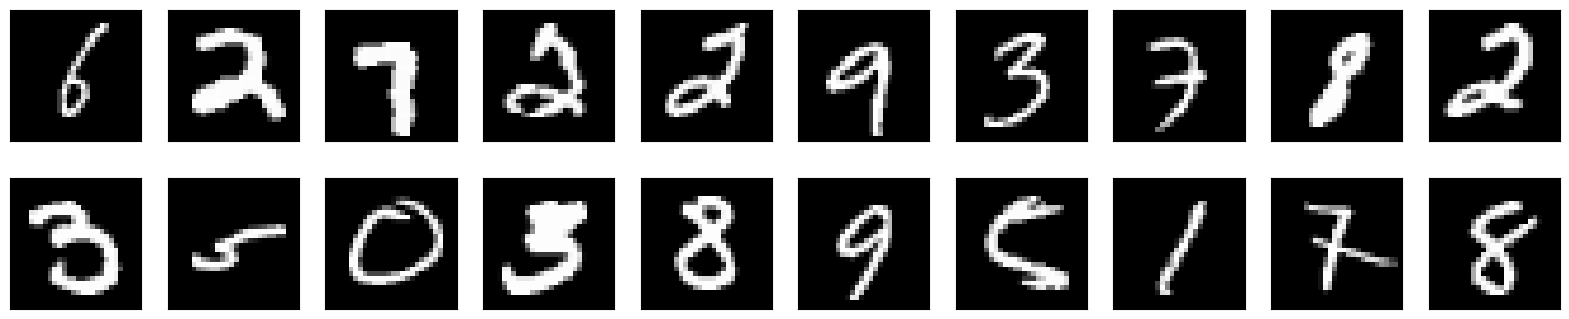

Training DenoisingAutoencoder with mse loss...


ValueError: too many values to unpack (expected 2)

In [15]:
# ------------------------------
# Step 1: Define Configuration
# ------------------------------

# Configuration
config = {
    "model_type": "dae",  # Options: "autoencoder", "vae", "dae"
    "model_name": "DenoisingAutoencoder",  # Options: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder", "BasicVAE", "ImprovedVAE", "FlexibleVAE", "ImprovedFlexibleVAE", "DenoisingAutoencoder"
    "code_dim": 50,  # Dimensionality of the embedding
    "loss_type": "mse",  # Options: "mse", "vicreg", "ntxent", "triplet"
    "noise_factor": 0.1,  # Noise factor for denoising autoencoders
    "temperature": 0.5,  # Temperature parameter for NT-Xent loss
    "margin": 1.0,  # Margin for Triplet Loss
    "epochs": 100,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_best": True,  # Whether to save the best model
    "save_path": "best_model.pth",  # Path to save the best model
    "beta": 1.0,  # Weight for KL divergence (VAE only)
    "alpha": 0.5,  # Weight for contrastive or triplet loss
    "fraction": 0.01,  # Fraction of the dataset to use
    "projection_dim": None,  # Optional projection head dimension for VAEs
    "strong_architecture": False,  # Whether to use a deeper architecture for DenoisingAutoencoder
    "input_shape": (1, 28, 28),  # Input shape for FlexibleVAE and ImprovedFlexibleVAE
}

# ------------------------------
# Step 2: Load and Preprocess Data
# ------------------------------

# Load Combined MNIST Dataset (Train + Test)
mnist_loader = data_utils.load_mnist_data(fraction=config["fraction"], batch_size=config["batch_size"], shuffle=True)

# Inspect Combined Dataset
for batch in mnist_loader:
    images, labels = batch
    print("Batch Shape:", images.shape, labels.shape)
    break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# ------------------------------
# Step 3: Initialize Model, Loss, and Optimizer
# ------------------------------

# Initialize the model
model_classes = {
    "BasicAutoencoder": encoder_models.BasicAutoencoder,
    "IntermediateAutoencoder": encoder_models.IntermediateAutoencoder,
    "AdvancedAutoencoder": encoder_models.AdvancedAutoencoder,
    "EnhancedAutoencoder": encoder_models.EnhancedAutoencoder,
    "BasicVAE": encoder_models.BasicVAE,
    "ImprovedVAE": encoder_models.ImprovedVAE,
    "FlexibleVAE": encoder_models.FlexibleVAE,
    "ImprovedFlexibleVAE": encoder_models.ImprovedFlexibleVAE,
    "DenoisingAutoencoder": encoder_models.DenoisingAutoencoder,
}

# Initialize model with appropriate arguments
if config["model_name"] in ["FlexibleVAE", "ImprovedFlexibleVAE"]:
    model = model_classes[config["model_name"]](
        input_shape=config["input_shape"],
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"]
    ).to(config["device"])
elif config["model_name"] == "DenoisingAutoencoder":
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"],
        strong_architecture=config["strong_architecture"]
    ).to(config["device"])
else:
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"]
    ).to(config["device"])

# # Define the loss function
# loss_functions = {
#     "mse": nn.MSELoss(),  # Reconstruction loss
#     "vae_loss": losses.vae_loss,  # VAE loss
#     "vicreg": cl_loss.VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
#     "ntxent": cl_loss.NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
#     "triplet": cl_loss.TripletLoss(margin=config["margin"]),  # Triplet loss
# }
# criterion = loss_functions[config["loss_type"]]

# Define the loss function
if config["model_type"] == "vae":
    criterion = losses.vae_loss  # Use VAE loss for VAEs
else:
    loss_functions = {
        "mse": nn.MSELoss(),  # Reconstruction loss
        "vicreg": cl_loss.VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
        "ntxent": cl_loss.NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
        "triplet": cl_loss.TripletLoss(margin=config["margin"]),  # Triplet loss
    }
    criterion = loss_functions[config["loss_type"]]

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 4: Train the Model
# ------------------------------

if config["model_type"] == "autoencoder":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_autoencoder(
        model=model,
        data_loader=mnist_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        epochs=config["epochs"],
        device=config["device"],
        noise_factor=config["noise_factor"],
        scheduler=scheduler,
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "triplet"] else None,
        triplet_data=(config["loss_type"] == "triplet"),
        augment_fn=cl_loss.augment if config["loss_type"] in ["vicreg", "ntxent"] else None,
    )

elif config["model_type"] == "vae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_vae(
        vae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        beta=config["beta"],
        alpha=config["alpha"],
        temperature=config["temperature"],
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent"] else None,
    )

elif config["model_type"] == "dae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_dae(
        dae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        noise_factor=config["noise_factor"],
        alpha=config["alpha"],
        temperature=config["temperature"],
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent"] else None,
        triplet_loss_fn=criterion if config["loss_type"] == "triplet" else None,
        ssim_func=losses.ssim if config["loss_type"] == "ssim" else None,
    )

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Generate embeddings
embeddings, labels = generate_embeddings(
    model=model,
    embedding_type=config["model_type"],
    data_loader=mnist_loader,
    device=config["device"],
)

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{config['model_type']}_{config['model_name']}_{config['loss_type']}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

# ------------------------------
# Step 6: Visualize Embeddings
# ------------------------------

# Visualize embeddings


In [ ]:
# ------------------------------
# Step 1: Define Configuration
# ------------------------------

# Configuration
config = {
    "model_name": "IntermediateAutoencoder",  # Options: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"
    "code_dim": 50,  # Dimensionality of the embedding
    "embedding_type": "autoencoders",  # Options: "autoencoders", "VAEs", "denoising_autoencoders"
    "loss_type": "mse",  # Options: "mse", "vicreg", "ntxent", "triplet"
    "noise_factor": 0.0,  # Noise factor for denoising autoencoders
    "temperature": 0.5,  # Temperature parameter for NT-Xent loss
    "margin": 1.0,  # Margin for Triplet Loss
    "epochs": 100,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# ------------------------------
# Step 2: Load and Preprocess Data
# ------------------------------

# Load MNIST data
train_data, test_data = data_utils.load_mnist_data()

# Preprocess images
train_data = data_utils.preprocess_images(train_data)
test_data = data_utils.preprocess_images(test_data)

# Create DataLoader
train_loader = data_utils.create_dataloader(train_data, batch_size=config["batch_size"], shuffle=True)
test_loader = data_utils.create_dataloader(test_data, batch_size=config["batch_size"], shuffle=False)

# ------------------------------
# Step 3: Initialize Model, Loss, and Optimizer
# ------------------------------

# Initialize the model
model_classes = {
    "BasicAutoencoder": encoder_models.BasicAutoencoder,
    "IntermediateAutoencoder": encoder_models.IntermediateAutoencoder,
    "AdvancedAutoencoder": encoder_models.AdvancedAutoencoder,
    "EnhancedAutoencoder": encoder_models.EnhancedAutoencoder,
}
model = model_classes[config["model_name"]](code_dim=config["code_dim"]).to(config["device"])

# Define the loss function
loss_functions = {
    "mse": nn.MSELoss(),  # Reconstruction loss
    "vicreg": cl_loss.VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
    "ntxent": cl_loss.NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
    "triplet": cl_loss.TripletLoss(margin=config["margin"]),  # Triplet loss
}
criterion = loss_functions[config["loss_type"]]

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 4: Train the Model
# ------------------------------

print(f"Training {config['model_name']} with {config['loss_type']} loss...")
encoder_training.train_autoencoder(
    model=model,
    data_loader=train_loader,
    loss_fn=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=config["epochs"],
    device=config["device"],
    noise_factor=config["noise_factor"] if config["embedding_type"] == "denoising_autoencoders" else 0.0,
    contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "triplet"] else None,
    augment_fn=cl_loss.augment if config["loss_type"] in ["vicreg", "ntxent"] else None,
    triplet_data=(config["loss_type"] == "triplet"),
)

# ------------------------------
# Step 5: Generate and Save Embeddings
# ------------------------------

# Generate embeddings
embeddings, labels = encoder_training.generate_embeddings(
    model=model,
    data_loader=test_loader,
    device=config["device"],
)

# Save embeddings
data_utils.save_embeddings(
    embeddings=embeddings,
    labels=labels,
    base_dir="./saved_embeddings",
    model_name=config["model_name"],
    loss_type=config["loss_type"],
    embedding_type=config["embedding_type"],
    save_format="pt",  # Options: "pt" (PyTorch) or "npy" (NumPy)
)

# Save the model
model_file = os.path.join("./saved_embeddings", f"{config['model_name']}_{config['loss_type']}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

# ------------------------------
# Step 6: Visualize Embeddings
# ------------------------------

# Visualize embeddings
data_utils.visualize_embeddings(embeddings, labels, title=f"{config['model_name']} Embeddings")

In [ ]:
class EnhancedAutoencoder(nn.Module):
    """
    A deep autoencoder with advanced reconstruction capabilities.

    Features:
    - Deeper architecture with additional convolutional and transposed convolutional layers.
    - Utilizes Batch Normalization and LeakyReLU activations.
    - Capable of learning highly expressive embeddings.

    Designed for datasets requiring intricate reconstructions.
    """
    def __init__(self, code_dim):
        super(EnhancedAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: (1, 28, 28)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # Output: (32, 14, 14)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 14, 14)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # Output: (64, 7, 7)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 7, 7)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)  # Output: (128, 3, 3)
        )

        self.fc_encoder = nn.Linear(128 * 3 * 3, code_dim)

        # Decoder with learned upsampling
        self.fc_decoder = nn.Linear(code_dim, 128 * 3 * 3)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (128, 3, 3)),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Learned upsampling
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Encoding
        encoded = self.encoder(x)
        encoded = encoded.view(batch_size, -1)
        encoded = self.fc_encoder(encoded)

        # Decoding
        decoded = self.fc_decoder(encoded)
        decoded = self.decoder(decoded)

        return encoded, decoded

In [ ]:
def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import numpy as np
from torch.utils.data import DataLoader

# ------------------------------
# Step 1: Define Contrastive Loss Functions
# ------------------------------

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        z = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = torch.matmul(z, z.T) / self.temperature
        mask = ~torch.eye(2 * batch_size, device=z.device).bool()
        positives = torch.cat([torch.diag(similarity_matrix, batch_size), torch.diag(similarity_matrix, -batch_size)])
        negatives = similarity_matrix.masked_select(mask).view(2 * batch_size, -1)
        numerator = torch.exp(positives)
        denominator = torch.sum(torch.exp(negatives), dim=-1)
        return -torch.mean(torch.log(numerator / denominator))

# VicReg Loss
class VicRegLoss(nn.Module):
    def __init__(self, lambda_var=25, mu_mean=25, nu_cov=1):
        super(VicRegLoss, self).__init__()
        self.lambda_var = lambda_var
        self.mu_mean = mu_mean
        self.nu_cov = nu_cov

    def forward(self, z1, z2):
        variance_loss = torch.mean(torch.relu(1 - torch.std(z1, dim=0))) + torch.mean(torch.relu(1 - torch.std(z2, dim=0)))
        mean_loss = torch.mean((torch.mean(z1, dim=0) - torch.mean(z2, dim=0))**2)
        z1_centered = z1 - z1.mean(dim=0)
        z2_centered = z2 - z2.mean(dim=0)
        covariance_matrix_z1 = torch.mm(z1_centered.T, z1_centered) / (z1.size(0) - 1)
        covariance_matrix_z2 = torch.mm(z2_centered.T, z2_centered) / (z2.size(0) - 1)
        covariance_loss = torch.sum(covariance_matrix_z1 ** 2) - torch.sum(torch.diag(covariance_matrix_z1) ** 2) + \
                          torch.sum(covariance_matrix_z2 ** 2) - torch.sum(torch.diag(covariance_matrix_z2) ** 2)
        return self.lambda_var * variance_loss + self.mu_mean * mean_loss + self.nu_cov * covariance_loss

# Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.criterion = nn.TripletMarginWithDistanceLoss(
            distance_function=lambda a, b: 1.0 - F.cosine_similarity(a, b),
            margin=self.margin
        )

    def forward(self, anchor, positive, negative):
        return self.criterion(anchor, positive, negative)

# ------------------------------
# Step 2: Define Augmentation Function
# ------------------------------

def augment(images):
    """
    Apply tensor-based augmentations to images.

    Args:
        images (torch.Tensor): Batch of images of shape (batch_size, 1, 28, 28).

    Returns:
        torch.Tensor: Augmented images of the same shape as input.
    """
    # Resize and crop (ensure output size matches input size)
    images = resize(images, size=[28, 28])

    # Random horizontal flip
    if torch.rand(1) > 0.5:
        images = hflip(images)

    return images

# ------------------------------
# Step 3: Define Training Function
# ------------------------------

def train_autoencoder(
    model,
    data_loader,
    loss_fn,
    optimizer,
    scheduler=None,
    epochs=10,
    device="cpu",
    noise_factor=0.0,
    augment_fn=None,
    contrastive_loss_fn=None,
    temperature=0.5,
    triplet_data=False,
):
    """
    Train an autoencoder model with support for contrastive learning, noise injection, and augmentations.

    Args:
        model (nn.Module): The autoencoder model.
        data_loader (DataLoader): DataLoader for training data.
        loss_fn (callable): Primary loss function (e.g., reconstruction loss).
        optimizer (torch.optim.Optimizer): Optimizer for the model.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler.
        epochs (int): Number of epochs to train.
        device (str): Device to train on ('cpu' or 'cuda').
        noise_factor (float): Factor for adding noise to input images (denoising autoencoder).
        augment_fn (callable, optional): Augmentation function for contrastive learning.
        contrastive_loss_fn (callable, optional): Contrastive loss function (e.g., NT-Xent, triplet loss).
        temperature (float): Temperature parameter for NT-Xent loss.
        triplet_data (bool): Whether the data_loader provides triplets (anchor, positive, negative).

    Returns:
        None: Prints loss values for each epoch.
    """
    model.to(device).train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            # Prepare data based on whether it's triplet data or not
            if triplet_data:
                anchor, positive, negative = batch
                anchor, positive, negative = (
                    anchor.to(device).float(),
                    positive.to(device).float(),
                    negative.to(device).float(),
                )
                images = anchor  # Use anchor as the primary input for reconstruction
            else:
                images, _ = batch
                images = images.to(device).float()

            # Add noise if specified
            if noise_factor > 0:
                noisy_images = images + noise_factor * torch.randn_like(images)
                noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
                encoded, decoded = model(noisy_images)
            else:
                encoded, decoded = model(images)

            # Compute reconstruction loss
            reconstruction_loss = loss_fn(decoded, images)

            # Compute contrastive loss if specified
            contrastive_loss_value = 0
            if contrastive_loss_fn is not None:
                if triplet_data:
                    # Triplet loss
                    positive_encoded, _ = model(positive)
                    negative_encoded, _ = model(negative)
                    contrastive_loss_value = contrastive_loss_fn(encoded, positive_encoded, negative_encoded)
                else:
                    # NT-Xent or other contrastive loss
                    if augment_fn:
                        augmented_1 = augment_fn(images)
                        augmented_2 = augment_fn(images)
                        z1, _ = model(augmented_1)
                        z2, _ = model(augmented_2)
                    else:
                        z1, z2 = encoded, encoded  # Use the same embeddings if no augmentation
                    contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature)

            # Total loss
            total_loss_value = reconstruction_loss + contrastive_loss_value

            # Backpropagation
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_loss += total_loss_value.item()

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Print epoch loss
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(data_loader):.4f}")

# ------------------------------
# Step 4: Configure Training Pipeline
# ------------------------------

# ------------------------------
# Step 1: Model Selection and Parameters
# ------------------------------

# Model selection and parameters
model_name = "IntermediateAutoencoder"  # Choose from: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Choose from: "autoencoders", "VAEs", "denoising_autoencoders"
loss_type = "mse"  # Choose from: "mse", "vicreg", "ntxent", "triplet"
noise_factor = 0.0  # Noise factor for denoising autoencoders
temperature = 0.5  # Temperature parameter for NT-Xent loss
margin = 1.0  # Margin for Triplet Loss

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()  # Reconstruction loss
elif loss_type == "vicreg":
    criterion = VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1)  # VicReg loss
elif loss_type == "ntxent":
    criterion = NTXentLoss(temperature=temperature)  # NT-Xent loss
elif loss_type == "triplet":
    criterion = TripletLoss(margin=margin)  # Triplet loss
else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 20 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 2: Training the Model
# ------------------------------

# Train the model
print(f"Training {model_name} with {loss_type} loss...")
train_autoencoder(
    model=model,
    data_loader=mnist_loader,  # Your DataLoader
    loss_fn=criterion,  # Primary loss function
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=100,
    device=device,
    noise_factor=noise_factor if embedding_type == "denoising_autoencoders" else 0.0,  # Add noise for denoising
    contrastive_loss_fn=criterion if loss_type in ["vicreg", "ntxent", "triplet"] else None,  # Optional: Contrastive loss
    augment_fn=augment if loss_type in ["vicreg", "ntxent"] else None,  # Optional: Augmentation function
    triplet_data=(loss_type == "triplet")  # Optional: Use triplet data
)

# ------------------------------
# Step 3: Generate Embeddings
# ------------------------------

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(
    model=model,
    data_loader=mnist_loader,  # Your DataLoader
    device=device
)

# ------------------------------
# Step 4: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

Training IntermediateAutoencoder with mse loss...
Epoch [1/100], Loss: 0.0518
Epoch [2/100], Loss: 0.0172
Epoch [3/100], Loss: 0.0141
Epoch [4/100], Loss: 0.0125
Epoch [5/100], Loss: 0.0116
Epoch [6/100], Loss: 0.0108
Epoch [7/100], Loss: 0.0103
Epoch [8/100], Loss: 0.0100
Epoch [9/100], Loss: 0.0096
Epoch [10/100], Loss: 0.0093
Epoch [11/100], Loss: 0.0091
Epoch [12/100], Loss: 0.0089
Epoch [13/100], Loss: 0.0087
Epoch [14/100], Loss: 0.0086
Epoch [15/100], Loss: 0.0084
Epoch [16/100], Loss: 0.0083
Epoch [17/100], Loss: 0.0082
Epoch [18/100], Loss: 0.0081
Epoch [19/100], Loss: 0.0080
Epoch [20/100], Loss: 0.0080
Epoch [21/100], Loss: 0.0072
Epoch [22/100], Loss: 0.0071
Epoch [23/100], Loss: 0.0071
Epoch [24/100], Loss: 0.0071
Epoch [25/100], Loss: 0.0071
Epoch [26/100], Loss: 0.0071
Epoch [27/100], Loss: 0.0070
Epoch [28/100], Loss: 0.0070
Epoch [29/100], Loss: 0.0070
Epoch [30/100], Loss: 0.0070
Epoch [31/100], Loss: 0.0070
Epoch [32/100], Loss: 0.0070
Epoch [33/100], Loss: 0.0070
Ep

TypeError: generate_embeddings() missing 1 required positional argument: 'embedding_type'

In [ ]:
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(
    model=model,
    embedding_type= embedding_type,
    data_loader=mnist_loader,  # Your DataLoader
    device=device
)

# ------------------------------
# Step 4: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

Generating embeddings using IntermediateAutoencoder with mse loss...
Embeddings saved in PyTorch format: ./saved_embeddings/embeddings/autoencoders_IntermediateAutoencoder_mse/IntermediateAutoencoder_mse_embeddings.pt
Model saved: ./saved_embeddings/embeddings/autoencoders_IntermediateAutoencoder_mse/IntermediateAutoencoder_mse.pth


In [ ]:
# ------------------------------
# Step 2: Train and Save Selected Model
# ------------------------------

# Model selection and parameters
model_name = "AdvancedAutoencoder"  # Change to desired model
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Change based on the embedding type
loss_type = "mse"  # Choose from "mse", "vicreg", "vae", "ssim", etc.

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "BasicVAE":
    model = BasicVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "VAEWithFCDecoder":
    model = VAEWithFCDecoder(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "ImprovedVAE":
    model = ImprovedVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "FlexibleVAE":
    model = FlexibleVAE(input_shape=(1, 28, 28), code_dim=code_dim).to(device)
elif model_name == "DenoisingAutoencoder":
    model = DenoisingAutoencoder(code_dim=code_dim, strong_architecture=False).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()
elif loss_type == "vicreg":
    criterion = VicRegLoss()
elif loss_type == "vae":
    criterion = vae_loss
elif loss_type == "ssim":
    criterion = vae_ssim_loss
else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 10 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
print(f"Training {model_name} with {loss_type} loss...")
if embedding_type == "autoencoders":
    train_autoencoder(model, mnist_loader, criterion, optimizer, epochs=100, device=device)
elif embedding_type == "VAEs":
    train_vae(model, mnist_loader, optimizer, loss_fn=vae_loss, epochs=10, device=device)
elif embedding_type == "denoising_autoencoders":
    train_denoising_autoencoder(model, mnist_loader, criterion, optimizer, noise_factor=0.1, epochs=10, device=device)
else:
    raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(model, mnist_loader, embedding_type, device=device)

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")


Training AdvancedAutoencoder with mse loss...
Epoch [1/100], Loss: 0.6372
Epoch [2/100], Loss: 0.3665
Epoch [3/100], Loss: 0.3064
Epoch [4/100], Loss: 0.2097
Epoch [5/100], Loss: 0.0671
Epoch [6/100], Loss: 0.0357
Epoch [7/100], Loss: 0.0296
Epoch [8/100], Loss: 0.0267
Epoch [9/100], Loss: 0.0248
Epoch [10/100], Loss: 0.0227
Epoch [11/100], Loss: 0.0216
Epoch [12/100], Loss: 0.0205
Epoch [13/100], Loss: 0.0197
Epoch [14/100], Loss: 0.0188
Epoch [15/100], Loss: 0.0180
Epoch [16/100], Loss: 0.0174
Epoch [17/100], Loss: 0.0167
Epoch [18/100], Loss: 0.0162
Epoch [19/100], Loss: 0.0158
Epoch [20/100], Loss: 0.0154
Epoch [21/100], Loss: 0.0149
Epoch [22/100], Loss: 0.0147
Epoch [23/100], Loss: 0.0144
Epoch [24/100], Loss: 0.0142
Epoch [25/100], Loss: 0.0138
Epoch [26/100], Loss: 0.0136
Epoch [27/100], Loss: 0.0135
Epoch [28/100], Loss: 0.0131
Epoch [29/100], Loss: 0.0128
Epoch [30/100], Loss: 0.0128
Epoch [31/100], Loss: 0.0124
Epoch [32/100], Loss: 0.0124
Epoch [33/100], Loss: 0.0121
Epoch 

In [ ]:
# ------------------------------
# Step 2: Train and Save Selected Model
# ------------------------------

# Model selection and parameters
model_name = "IntermediateAutoencoder"  # Change to desired model
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Change based on the embedding type
loss_type = "mse"  # Choose from "mse", "vicreg", "vae", "ssim", etc.

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "BasicVAE":
    model = BasicVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "VAEWithFCDecoder":
    model = VAEWithFCDecoder(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "ImprovedVAE":
    model = ImprovedVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "FlexibleVAE":
    model = FlexibleVAE(input_shape=(1, 28, 28), code_dim=code_dim).to(device)
elif model_name == "DenoisingAutoencoder":
    model = DenoisingAutoencoder(code_dim=code_dim, strong_architecture=False).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()
elif loss_type == "vicreg":
    criterion = VicRegLoss()
elif loss_type == "vae":
    criterion = vae_loss
elif loss_type == "ssim":
    criterion = vae_ssim_loss
else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 10 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
print(f"Training {model_name} with {loss_type} loss...")
if embedding_type == "autoencoders":
    train_autoencoder(model, mnist_loader, criterion, optimizer, epochs=100, device=device)
elif embedding_type == "VAEs":
    train_vae(model, mnist_loader, optimizer, loss_fn=vae_loss, epochs=10, device=device)
elif embedding_type == "denoising_autoencoders":
    train_denoising_autoencoder(model, mnist_loader, criterion, optimizer, noise_factor=0.1, epochs=10, device=device)
else:
    raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(model, mnist_loader, embedding_type, device=device)

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")


Training IntermediateAutoencoder with mse loss...
Epoch [1/100], Loss: 0.3440
Epoch [2/100], Loss: 0.0693
Epoch [3/100], Loss: 0.0423
Epoch [4/100], Loss: 0.0327
Epoch [5/100], Loss: 0.0277
Epoch [6/100], Loss: 0.0246
Epoch [7/100], Loss: 0.0222
Epoch [8/100], Loss: 0.0205
Epoch [9/100], Loss: 0.0191
Epoch [10/100], Loss: 0.0181
Epoch [11/100], Loss: 0.0174
Epoch [12/100], Loss: 0.0165
Epoch [13/100], Loss: 0.0157
Epoch [14/100], Loss: 0.0149
Epoch [15/100], Loss: 0.0147
Epoch [16/100], Loss: 0.0139
Epoch [17/100], Loss: 0.0136
Epoch [18/100], Loss: 0.0136
Epoch [19/100], Loss: 0.0130
Epoch [20/100], Loss: 0.0128
Epoch [21/100], Loss: 0.0124
Epoch [22/100], Loss: 0.0122
Epoch [23/100], Loss: 0.0116
Epoch [24/100], Loss: 0.0116
Epoch [25/100], Loss: 0.0114
Epoch [26/100], Loss: 0.0111
Epoch [27/100], Loss: 0.0111
Epoch [28/100], Loss: 0.0109
Epoch [29/100], Loss: 0.0106
Epoch [30/100], Loss: 0.0103
Epoch [31/100], Loss: 0.0106
Epoch [32/100], Loss: 0.0103
Epoch [33/100], Loss: 0.0101
Ep

In [ ]:
# ------------------------------
# Step 2: Train and Save Selected Model
# ------------------------------

# Model selection and parameters
model_name = "BasicAutoencoder"  # Change to desired model
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Change based on the embedding type
loss_type = "mse"  # Choose from "mse", "vicreg", "vae", "ssim", etc.

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "BasicVAE":
    model = BasicVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "VAEWithFCDecoder":
    model = VAEWithFCDecoder(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "ImprovedVAE":
    model = ImprovedVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "FlexibleVAE":
    model = FlexibleVAE(input_shape=(1, 28, 28), code_dim=code_dim).to(device)
elif model_name == "DenoisingAutoencoder":
    model = DenoisingAutoencoder(code_dim=code_dim, strong_architecture=False).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()
elif loss_type == "vicreg":
    criterion = VicRegLoss()
elif loss_type == "vae":
    criterion = vae_loss
elif loss_type == "ssim":
    criterion = vae_ssim_loss
else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 10 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
print(f"Training {model_name} with {loss_type} loss...")
if embedding_type == "autoencoders":
    train_autoencoder(model, mnist_loader, criterion, optimizer, epochs=100, device=device)
elif embedding_type == "VAEs":
    train_vae(model, mnist_loader, optimizer, loss_fn=vae_loss, epochs=10, device=device)
elif embedding_type == "denoising_autoencoders":
    train_denoising_autoencoder(model, mnist_loader, criterion, optimizer, noise_factor=0.1, epochs=10, device=device)
else:
    raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(model, mnist_loader, embedding_type, device=device)

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")


Training BasicAutoencoder with mse loss...
Epoch [1/100], Loss: 0.3403
Epoch [2/100], Loss: 0.2061
Epoch [3/100], Loss: 0.1146
Epoch [4/100], Loss: 0.0868
Epoch [5/100], Loss: 0.0737
Epoch [6/100], Loss: 0.0653
Epoch [7/100], Loss: 0.0595
Epoch [8/100], Loss: 0.0546
Epoch [9/100], Loss: 0.0507
Epoch [10/100], Loss: 0.0478
Epoch [11/100], Loss: 0.0455
Epoch [12/100], Loss: 0.0433
Epoch [13/100], Loss: 0.0413
Epoch [14/100], Loss: 0.0398
Epoch [15/100], Loss: 0.0387
Epoch [16/100], Loss: 0.0373
Epoch [17/100], Loss: 0.0362
Epoch [18/100], Loss: 0.0352
Epoch [19/100], Loss: 0.0340
Epoch [20/100], Loss: 0.0332
Epoch [21/100], Loss: 0.0327
Epoch [22/100], Loss: 0.0319
Epoch [23/100], Loss: 0.0312
Epoch [24/100], Loss: 0.0305
Epoch [25/100], Loss: 0.0299
Epoch [26/100], Loss: 0.0295
Epoch [27/100], Loss: 0.0291
Epoch [28/100], Loss: 0.0286
Epoch [29/100], Loss: 0.0280
Epoch [30/100], Loss: 0.0278
Epoch [31/100], Loss: 0.0274
Epoch [32/100], Loss: 0.0269
Epoch [33/100], Loss: 0.0267
Epoch [34

In [ ]:
from skimage.metrics import structural_similarity as ssim


# ------------------------------
# Step 2: Train and Save Selected Model
# ------------------------------

# Model selection and parameters
model_name = "EnhancedAutoencoder"  # Change to desired model
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Change based on the embedding type
loss_type = "mse"  # Choose from "mse", "vicreg", "vae", "ssim", etc.

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "BasicVAE":
    model = BasicVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "VAEWithFCDecoder":
    model = VAEWithFCDecoder(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "ImprovedVAE":
    model = ImprovedVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "FlexibleVAE":
    model = FlexibleVAE(input_shape=(1, 28, 28), code_dim=code_dim).to(device)
elif model_name == "DenoisingAutoencoder":
    model = DenoisingAutoencoder(code_dim=code_dim, strong_architecture=False).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function and corresponding training function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_autoencoder
    elif model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder

elif loss_type == "vicreg":
    criterion = VicRegLoss()  # VicReg loss requires a different training procedure
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_triplet_loss  # Assuming triplet loss works for VicReg
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VicReg loss.")

elif loss_type == "vae":
    criterion = vae_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae  # Use VAE training function for VAE loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE loss.")

elif loss_type == "ssim":
    criterion = ssim  # Assuming SSIM loss function exists
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim  # Train using SSIM-based loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with SSIM loss.")

elif loss_type == "dae":
    criterion = nn.MSELoss()
    if model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder  # Use DAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE loss.")

elif loss_type == "dae_contrastive":
    criterion = nn.MSELoss()  # DAE contrastive will use triplet loss or contrastive loss
    if model_name == "DenoisingAutoencoder":
        train_function = train_dae_ssim_contrastive  # Train DAE with contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE contrastive loss.")

elif loss_type == "ntxent":
    criterion = nt_xent_loss
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_ntxent_loss  # NT-Xent loss for contrastive learning
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with NT-Xent loss.")

elif loss_type == "vae_improved":
    criterion = vae_loss
    if model_name in ["ImprovedVAE"]:
        train_function = train_vae_improved  # Use improved VAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with improved VAE loss.")

elif loss_type == "vae_ssim_contrastive":
    criterion = vae_ssim_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim_contrastive  # Train using SSIM + contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE SSIM contrastive loss.")

else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 10 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model using the selected function
print(f"Training {model_name} with {loss_type} loss...")
train_function(model, mnist_loader, criterion, optimizer, epochs=20, device=device, scheduler=scheduler)

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(model, mnist_loader, embedding_type, device=device)

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")


Training EnhancedAutoencoder with mse loss...


TypeError: train_autoencoder() got an unexpected keyword argument 'scheduler'

In [ ]:
from skimage.metrics import structural_similarity as ssim


# ------------------------------
# Step 2: Train and Save Selected Model
# ------------------------------

# Model selection and parameters
model_name = "FlexibleVAE"  # Change to desired model
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Change based on the embedding type
loss_type = "vae"  # Choose from "mse", "vicreg", "vae", "ssim", etc.

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "BasicVAE":
    model = BasicVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "VAEWithFCDecoder":
    model = VAEWithFCDecoder(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "ImprovedVAE":
    model = ImprovedVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "FlexibleVAE":
    model = FlexibleVAE(input_shape=(1, 28, 28), code_dim=code_dim).to(device)
elif model_name == "DenoisingAutoencoder":
    model = DenoisingAutoencoder(code_dim=code_dim, strong_architecture=False).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function and corresponding training function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_autoencoder
    elif model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder

elif loss_type == "vicreg":
    criterion = VicRegLoss()  # VicReg loss requires a different training procedure
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_triplet_loss  # Assuming triplet loss works for VicReg
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VicReg loss.")

elif loss_type == "vae":
    criterion = vae_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae  # Use VAE training function for VAE loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE loss.")

elif loss_type == "ssim":
    criterion = ssim  # Assuming SSIM loss function exists
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim  # Train using SSIM-based loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with SSIM loss.")

elif loss_type == "dae":
    criterion = nn.MSELoss()
    if model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder  # Use DAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE loss.")

elif loss_type == "dae_contrastive":
    criterion = nn.MSELoss()  # DAE contrastive will use triplet loss or contrastive loss
    if model_name == "DenoisingAutoencoder":
        train_function = train_dae_ssim_contrastive  # Train DAE with contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE contrastive loss.")

elif loss_type == "ntxent":
    criterion = nt_xent_loss
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_ntxent_loss  # NT-Xent loss for contrastive learning
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with NT-Xent loss.")

elif loss_type == "vae_improved":
    criterion = vae_loss
    if model_name in ["ImprovedVAE"]:
        train_function = train_vae_improved  # Use improved VAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with improved VAE loss.")

elif loss_type == "vae_ssim_contrastive":
    criterion = vae_ssim_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim_contrastive  # Train using SSIM + contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE SSIM contrastive loss.")

else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 10 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model using the selected function
print(f"Training {model_name} with {loss_type} loss...")
train_function(model, mnist_loader, criterion, optimizer, epochs=200, device=device, scheduler=scheduler)

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(model, mnist_loader, embedding_type, device=device)

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")


Training FlexibleVAE with vae loss...


TypeError: 'function' object is not iterable

In [ ]:
from skimage.metrics import structural_similarity as ssim


# ------------------------------
# Step 2: Train and Save Selected Model
# ------------------------------

# Model selection and parameters
model_name = "AdvancedAutoencoder"  # Change to desired model
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Change based on the embedding type
loss_type = "ntxent"  # Choose from "mse", "vicreg", "vae", "ssim", etc.

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "BasicVAE":
    model = BasicVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "VAEWithFCDecoder":
    model = VAEWithFCDecoder(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "ImprovedVAE":
    model = ImprovedVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "FlexibleVAE":
    model = FlexibleVAE(input_shape=(1, 28, 28), code_dim=code_dim).to(device)
elif model_name == "DenoisingAutoencoder":
    model = DenoisingAutoencoder(code_dim=code_dim, strong_architecture=False).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function and corresponding training function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_autoencoder
    elif model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder

elif loss_type == "vicreg":
    criterion = VicRegLoss()  # VicReg loss requires a different training procedure
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_triplet_loss  # Assuming triplet loss works for VicReg
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VicReg loss.")

elif loss_type == "vae":
    criterion = vae_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae  # Use VAE training function for VAE loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE loss.")

elif loss_type == "ssim":
    criterion = ssim  # Assuming SSIM loss function exists
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim  # Train using SSIM-based loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with SSIM loss.")

elif loss_type == "dae":
    criterion = nn.MSELoss()
    if model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder  # Use DAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE loss.")

elif loss_type == "dae_contrastive":
    criterion = nn.MSELoss()  # DAE contrastive will use triplet loss or contrastive loss
    if model_name == "DenoisingAutoencoder":
        train_function = train_dae_ssim_contrastive  # Train DAE with contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE contrastive loss.")

elif loss_type == "ntxent":
    criterion = nt_xent_loss
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_ntxent_loss  # NT-Xent loss for contrastive learning
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with NT-Xent loss.")

elif loss_type == "vae_improved":
    criterion = vae_loss
    if model_name in ["ImprovedVAE"]:
        train_function = train_vae_improved  # Use improved VAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with improved VAE loss.")

elif loss_type == "vae_ssim_contrastive":
    criterion = vae_ssim_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim_contrastive  # Train using SSIM + contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE SSIM contrastive loss.")

else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 10 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model using the selected function
print(f"Training {model_name} with {loss_type} loss...")
train_function(model, mnist_loader, criterion, optimizer, epochs=200, device=device, scheduler=scheduler)

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(model, mnist_loader, embedding_type, device=device)

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")


Training AdvancedAutoencoder with ntxent loss...
Epoch [1/200], Loss: 3.2167
Epoch [2/200], Loss: 3.1131
Epoch [3/200], Loss: 3.0889
Epoch [4/200], Loss: 3.0769
Epoch [5/200], Loss: 3.0689
Epoch [6/200], Loss: 3.0646
Epoch [7/200], Loss: 3.0587
Epoch [8/200], Loss: 3.0553
Epoch [9/200], Loss: 3.0534
Epoch [10/200], Loss: 3.0497
Epoch [11/200], Loss: 3.0399
Epoch [12/200], Loss: 3.0386
Epoch [13/200], Loss: 3.0380
Epoch [14/200], Loss: 3.0374
Epoch [15/200], Loss: 3.0367
Epoch [16/200], Loss: 3.0362
Epoch [17/200], Loss: 3.0360
Epoch [18/200], Loss: 3.0358
Epoch [19/200], Loss: 3.0352
Epoch [20/200], Loss: 3.0348
Epoch [21/200], Loss: 3.0337
Epoch [22/200], Loss: 3.0331
Epoch [23/200], Loss: 3.0336
Epoch [24/200], Loss: 3.0332
Epoch [25/200], Loss: 3.0330
Epoch [26/200], Loss: 3.0332
Epoch [27/200], Loss: 3.0334
Epoch [28/200], Loss: 3.0329
Epoch [29/200], Loss: 3.0338
Epoch [30/200], Loss: 3.0334
Epoch [31/200], Loss: 3.0331
Epoch [32/200], Loss: 3.0330
Epoch [33/200], Loss: 3.0332
Epo

KeyboardInterrupt: 

In [ ]:
from skimage.metrics import structural_similarity as ssim


# ------------------------------
# Step 2: Train and Save Selected Model
# ------------------------------

# Model selection and parameters
model_name = "FlexibleVAE"  # Change to desired model
code_dim = 50  # Dimensionality of the embedding
embedding_type = "autoencoders"  # Change based on the embedding type
loss_type = "vae"  # Choose from "mse", "vicreg", "vae", "ssim", etc.

# Initialize the model
if model_name == "BasicAutoencoder":
    model = BasicAutoencoder(code_dim=code_dim).to(device)
elif model_name == "IntermediateAutoencoder":
    model = IntermediateAutoencoder(code_dim=code_dim).to(device)
elif model_name == "AdvancedAutoencoder":
    model = AdvancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "EnhancedAutoencoder":
    model = EnhancedAutoencoder(code_dim=code_dim).to(device)
elif model_name == "BasicVAE":
    model = BasicVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "VAEWithFCDecoder":
    model = VAEWithFCDecoder(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "ImprovedVAE":
    model = ImprovedVAE(input_dim=1, code_dim=code_dim).to(device)
elif model_name == "FlexibleVAE":
    model = FlexibleVAE(input_shape=(1, 28, 28), code_dim=code_dim).to(device)
elif model_name == "DenoisingAutoencoder":
    model = DenoisingAutoencoder(code_dim=code_dim, strong_architecture=False).to(device)
else:
    raise ValueError(f"Model '{model_name}' is not recognized.")

# Define the loss function and corresponding training function
if loss_type == "mse":
    criterion = torch.nn.MSELoss()
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_autoencoder
    elif model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder

elif loss_type == "vicreg":
    criterion = VicRegLoss()  # VicReg loss requires a different training procedure
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_triplet_loss  # Assuming triplet loss works for VicReg
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VicReg loss.")

elif loss_type == "vae":
    criterion = vae_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae  # Use VAE training function for VAE loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE loss.")

elif loss_type == "ssim":
    criterion = ssim  # Assuming SSIM loss function exists
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim  # Train using SSIM-based loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with SSIM loss.")

elif loss_type == "dae":
    criterion = nn.MSELoss()
    if model_name == "DenoisingAutoencoder":
        train_function = train_denoising_autoencoder  # Use DAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE loss.")

elif loss_type == "dae_contrastive":
    criterion = nn.MSELoss()  # DAE contrastive will use triplet loss or contrastive loss
    if model_name == "DenoisingAutoencoder":
        train_function = train_dae_ssim_contrastive  # Train DAE with contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with DAE contrastive loss.")

elif loss_type == "ntxent":
    criterion = nt_xent_loss
    if model_name in ["BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder"]:
        train_function = train_with_ntxent_loss  # NT-Xent loss for contrastive learning
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with NT-Xent loss.")

elif loss_type == "vae_improved":
    criterion = vae_loss
    if model_name in ["ImprovedVAE"]:
        train_function = train_vae_improved  # Use improved VAE training function
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with improved VAE loss.")

elif loss_type == "vae_ssim_contrastive":
    criterion = vae_ssim_loss
    if model_name in ["BasicVAE", "VAEWithFCDecoder", "ImprovedVAE", "FlexibleVAE"]:
        train_function = train_vae_ssim_contrastive  # Train using SSIM + contrastive loss
    else:
        raise ValueError(f"Model '{model_name}' is not compatible with VAE SSIM contrastive loss.")

else:
    raise ValueError(f"Loss type '{loss_type}' is not recognized.")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define scheduler (e.g., StepLR to reduce learning rate every 10 epochs by a factor of 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model using the selected function
print(f"Training {model_name} with {loss_type} loss...")
train_function(model, mnist_loader, criterion, optimizer, epochs=200, device=device, scheduler=scheduler)

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{embedding_type}_{model_name}_{loss_type}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            if embedding_type == "autoencoders":
                encoded, _ = model(images)
            elif embedding_type == "VAEs":
                mu, _, _ = model(images)
                encoded = mu  # Use the mean of the latent space
            elif embedding_type == "denoising_autoencoders":
                _, _, encoded = model(images)
            else:
                raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

            embeddings.append(encoded.cpu())
            labels.append(label_batch)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    return embeddings, labels

# Generate embeddings
print(f"Generating embeddings using {model_name} with {loss_type} loss...")
embeddings, labels = generate_embeddings(model, mnist_loader, embedding_type, device=device)

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")


In [ ]:
# ------------------------------
# Step 1: Configuration
# ------------------------------

save_format = "pt"  # Change to "npy" if needed

# Ensure valid save format
if save_format not in ['pt', 'npy']:
    print(f"Invalid save format: {save_format}. Defaulting to 'pt'.")
    save_format = 'pt'

# Define model and loss type for naming conventions (update as needed)
model_name = "matrix_factorization"  # Example model name
loss_type = "default_loss"  # Update this as necessary (e.g., "mse", "contrastive", etc.)

# ------------------------------
# Step 2: Matrix Factorization
# ------------------------------

# Extract flattened images and labels
sampled_x, sampled_y = mnist_loader.dataset.tensors[0].numpy(), mnist_loader.dataset.tensors[1].numpy()

print("Processing matrix factorization models (PCA, SVD, NMF)...")
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

factorized_embeddings, factorized_labels = process_matrix_factorization(
    sampled_x, sampled_y, n_components=50
)
for method, embeddings in factorized_embeddings.items():
    embedding_subdir = f"matrix_factorization_{method}"
    embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    if save_format == "pt":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_{method}_embeddings.pt")
        torch.save({"embeddings": embeddings, "labels": factorized_labels}, embedding_file)
        print(f"{method} embeddings saved in PyTorch format: {embedding_file}")
    elif save_format == "npy":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_{method}_embeddings.npy")
        np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": factorized_labels.numpy()})
        print(f"{method} embeddings saved in NumPy format: {embedding_file}")
    else:
        raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 3: SIFT Features
# ------------------------------

print("Processing SIFT features...")
sift_features = apply_sift(sampled_x, n_features=50)
sift_labels = torch.tensor(sampled_y, dtype=torch.long)

embedding_subdir = "sift_features"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_sift_embeddings.pt")
    torch.save({"embeddings": torch.tensor(sift_features), "labels": sift_labels}, embedding_file)
    print(f"SIFT embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_sift_embeddings.npy")
    np.save(embedding_file, {"embeddings": sift_features, "labels": sift_labels.numpy()})
    print(f"SIFT embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 4: Kernel PCA
# ------------------------------

print("Processing Kernel PCA...")
kernel_pca_features, kernel_pca_labels = process_feature_extraction(
    sampled_x, sampled_y, n_features=50, kernel="rbf", n_components=50
)
for method, embeddings in kernel_pca_features.items():
    embedding_subdir = f"kernel_pca_{method}"
    embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    if save_format == "pt":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_kernel_pca_{method}_embeddings.pt")
        torch.save({"embeddings": embeddings, "labels": kernel_pca_labels}, embedding_file)
        print(f"{method} Kernel PCA embeddings saved in PyTorch format: {embedding_file}")
    elif save_format == "npy":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_kernel_pca_{method}_embeddings.npy")
        np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": kernel_pca_labels.numpy()})
        print(f"{method} Kernel PCA embeddings saved in NumPy format: {embedding_file}")
    else:
        raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 5: Normalizing Flow
# ------------------------------

print("Processing Normalizing Flow...")
for method, embeddings in factorized_embeddings.items():
    # Initialize Normalizing Flow model
    input_dim = embeddings.size(1)
    nf_model = NormalizingFlowModel(input_dim=input_dim, num_flows=4)
    nf_model.to(device)

    # Train Normalizing Flow model
    trained_nf_model = train_nf_model(
        nf_model, embeddings, num_epochs=200, lr=1e-3, batch_size=128
    )

    # Refine embeddings
    with torch.no_grad():
        refined_embeddings, _ = trained_nf_model(embeddings)

        embedding_subdir = f"normalizing_flow_{method}"
        embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
        os.makedirs(embedding_dir, exist_ok=True)

        if save_format == "pt":
            embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_normalizing_flow_{method}_refined_embeddings.pt")
            torch.save({"embeddings": refined_embeddings, "labels": factorized_labels}, embedding_file)
            print(f"{method} refined embeddings (Normalizing Flow) saved in PyTorch format: {embedding_file}")
        elif save_format == "npy":
            embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_normalizing_flow_{method}_refined_embeddings.npy")
            np.save(embedding_file, {"embeddings": refined_embeddings.numpy(), "labels": factorized_labels.numpy()})
            print(f"{method} refined embeddings (Normalizing Flow) saved in NumPy format: {embedding_file}")
        else:
            raise ValueError(f"Unsupported save format: {save_format}")

print("Feature extraction and normalizing flow processing complete!")


Processing matrix factorization models (PCA, SVD, NMF)...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_PCA/matrix_factorization_default_loss_PCA_embeddings.pt
SVD embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_SVD/matrix_factorization_default_loss_SVD_embeddings.pt
NMF embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_NMF/matrix_factorization_default_loss_NMF_embeddings.pt
Processing SIFT features...
SIFT embeddings saved in PyTorch format: ./saved_embeddings/embeddings/sift_features/matrix_factorization_default_loss_sift_embeddings.pt
Processing Kernel PCA...
SIFT Kernel PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/kernel_pca_SIFT/matrix_factorization_default_loss_kernel_pca_SIFT_embeddings.pt
Kernel PCA Kernel PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/kernel_pca_Kernel PCA/matrix_factorization_default_loss_kernel_pca_Kernel PCA_embeddings.pt
Processing Normalizing Flo